<a href="https://colab.research.google.com/github/chingu-voyages/v51-tier3-team-39/blob/main/marlissa_chingu_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



In [ ]:
merged_dataset = pd.read_csv(r"C:\Users\Marlissa\Downloads\chingu\chingu_datasets\merged_dataset_final.csv")

In [ ]:
# Join all reviews in each list into a single string if they're in list format
merged_dataset['all_quotes'] = merged_dataset['all_quotes'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else '')

In [ ]:
merged_dataset.columns

Index(['movie_id', 'movie_year', 'movie_title', 'rating', 'original_language',
       'runtime_in_minutes', 'critic_score', 'user_score',
       'average_combined_score', 'critic_review_count', 'user_review_count',
       'all_quotes'],
      dtype='object')

In [ ]:
merged_dataset['all_quotes'].head()

0    The primitive silent landmark has more charm a...
1    A controversial, explicitly racist, but landma...
2    The sheer audacity of the film's physical and ...
3    Combinando com perfeio toques comoventes e eng...
4    It's remarkable, by contrast with all the film...
Name: all_quotes, dtype: object

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Rejoin tokens into a single string
    text = ' '.join(tokens)
    return text

# Apply preprocessing to the 'all_quotes' column
merged_dataset['cleaned_quotes'] = merged_dataset['all_quotes'].apply(preprocess_text)

# View the first few cleaned quotes
print(merged_dataset[['movie_title', 'cleaned_quotes']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marlissa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                   movie_title  \
0           A Trip to the Moon   
1        The Birth of a Nation   
2  The Cabinet of Dr. Caligari   
3                      The Kid   
4                    Nosferatu   

                                      cleaned_quotes  
0  primitive silent landmark charm originality ma...  
1  controversial explicitly racist landmark ameri...  
2  sheer audacity films physical psychological co...  
3  combinando com perfeio toques comoventes e eng...  
4  remarkable contrast films appropriated stair s...  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the 'cleaned_quotes' column
tfidf_matrix = vectorizer.fit_transform(merged_dataset['cleaned_quotes'])

# Convert to DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# View the TF-IDF matrix for the first few movies
print(tfidf_df.head())


       able  absolute  absolutely       act     acted    acting    action  \
0  0.014164  0.007072    0.021066  0.000000  0.001329  0.010917  0.012700   
1  0.008372  0.002044    0.007609  0.018069  0.002880  0.017350  0.020185   
2  0.013596  0.011062    0.018307  0.009292  0.006237  0.034580  0.004470   
3  0.014829  0.015035    0.017625  0.007755  0.007064  0.034815  0.014626   
4  0.009971  0.009223    0.010255  0.004587  0.003250  0.027139  0.006729   

      actor    actors   actress  ...      year     years       yes      york  \
0  0.001279  0.014805  0.000000  ...  0.013251  0.111404  0.006357  0.000000   
1  0.001848  0.028795  0.001172  ...  0.008703  0.038564  0.033063  0.001626   
2  0.002000  0.022268  0.001269  ...  0.008951  0.047651  0.009943  0.000880   
3  0.038515  0.015133  0.001437  ...  0.012806  0.076073  0.007884  0.000000   
4  0.011465  0.009050  0.000661  ...  0.006382  0.058171  0.010362  0.000459   

      youll     young   younger     youre     youve    z

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1025
           1       0.87      0.86      0.87      1022

    accuracy                           0.87      2047
   macro avg       0.87      0.87      0.87      2047
weighted avg       0.87      0.87      0.87      2047



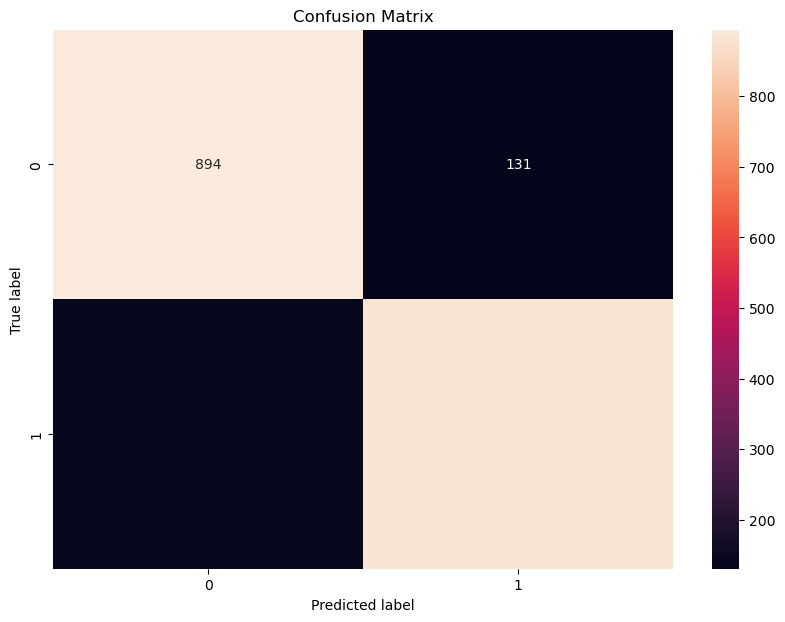

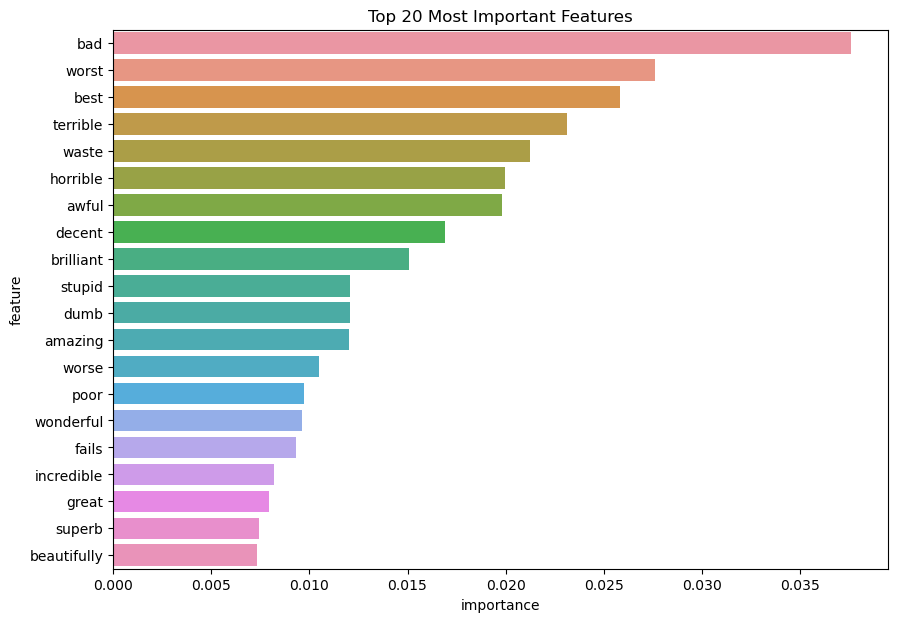

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'merged_dataset' and 'tfidf_df' are already defined from previous code

# Add additional features
merged_dataset['quote_count'] = merged_dataset['all_quotes'].apply(lambda x: len(str(x).split('.')))
merged_dataset['avg_quote_length'] = merged_dataset['all_quotes'].apply(lambda x: np.mean([len(quote.split()) for quote in str(x).split('.')]))

# Combine TF-IDF features with additional features
X = np.hstack((tfidf_matrix.toarray(), merged_dataset[['quote_count', 'avg_quote_length']].values))

# Create target variable (using average_combined_score)
# Let's consider movies with above-median scores as 'good'
median_score = merged_dataset['average_combined_score'].median()
y = (merged_dataset['average_combined_score'] > median_score).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Feature importance
feature_names = vectorizer.get_feature_names_out().tolist() + ['quote_count', 'avg_quote_length']
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': rf_classifier.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10,7))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 20 Most Important Features')
plt.show()

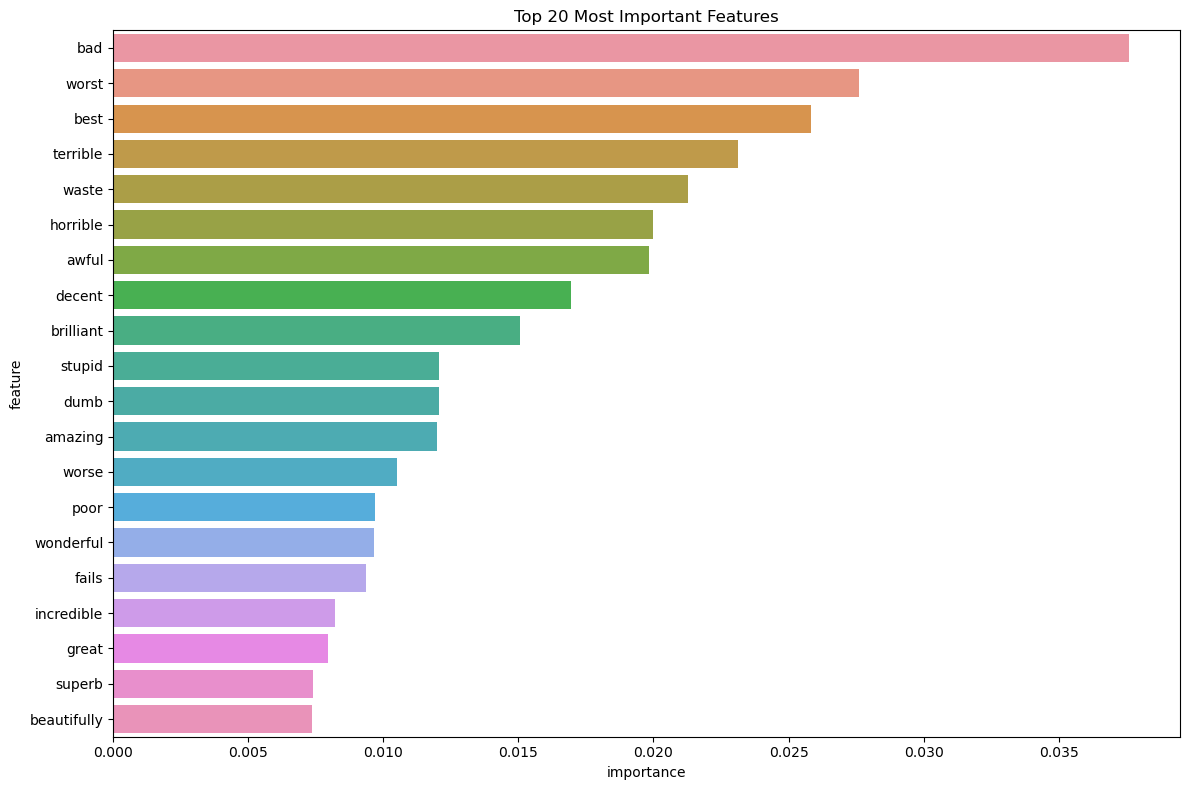

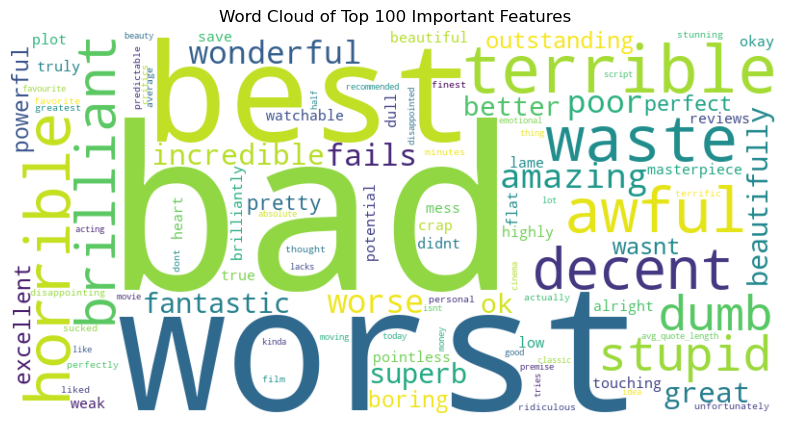

Sample of Misclassified Movies:
            movie_title  average_combined_score  \
3518    Never Back Down                    7.19   
2753  I Heart Huckabees                    7.71   
8509               CODA                    8.78   
3070     Lady Vengeance                    8.31   
3837    Valentine's Day                    6.40   

                                             all_quotes  
3518  Yesterday's Fight Club is today's "Combat Club...  
2753  If... you [get] the impression that this is al...  
8509  Heart sometimes beats prestige and we couldn't...  
3070  Hands down, the best conclusion to a trilogy, ...  
3837  Rates somewhere between a pink carnation from ...  


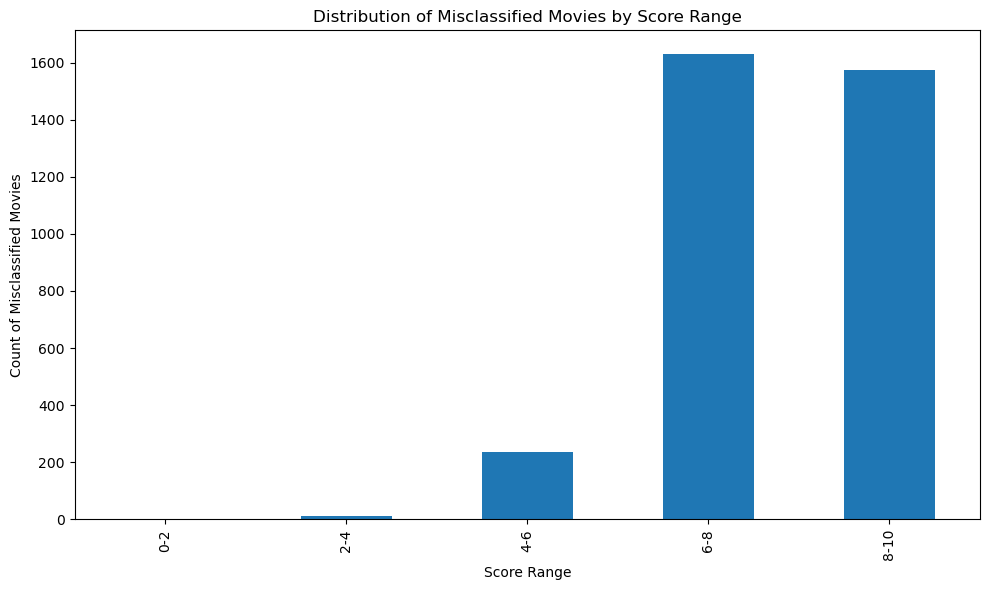

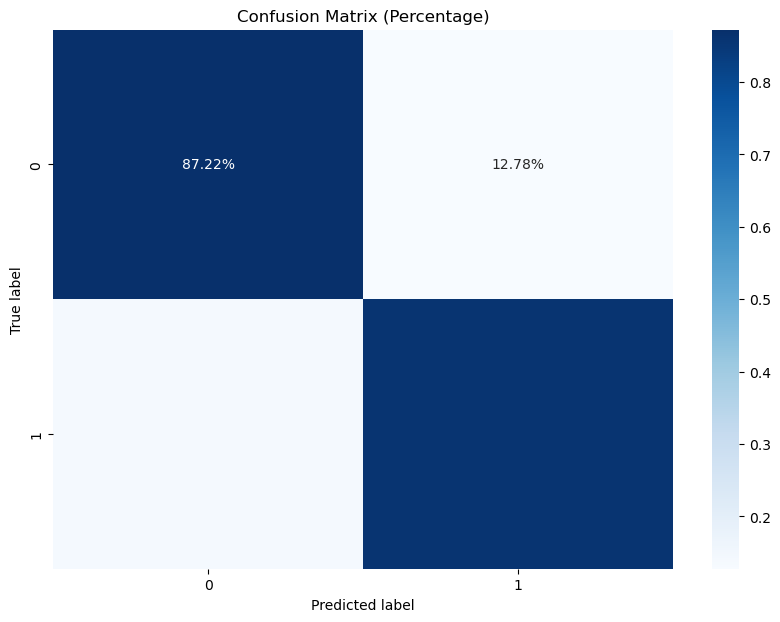

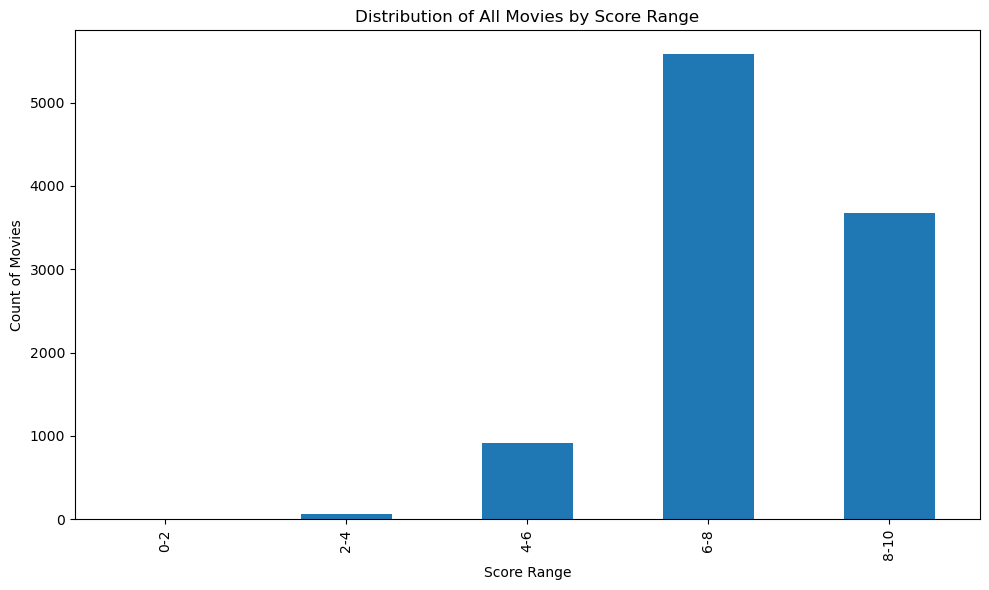

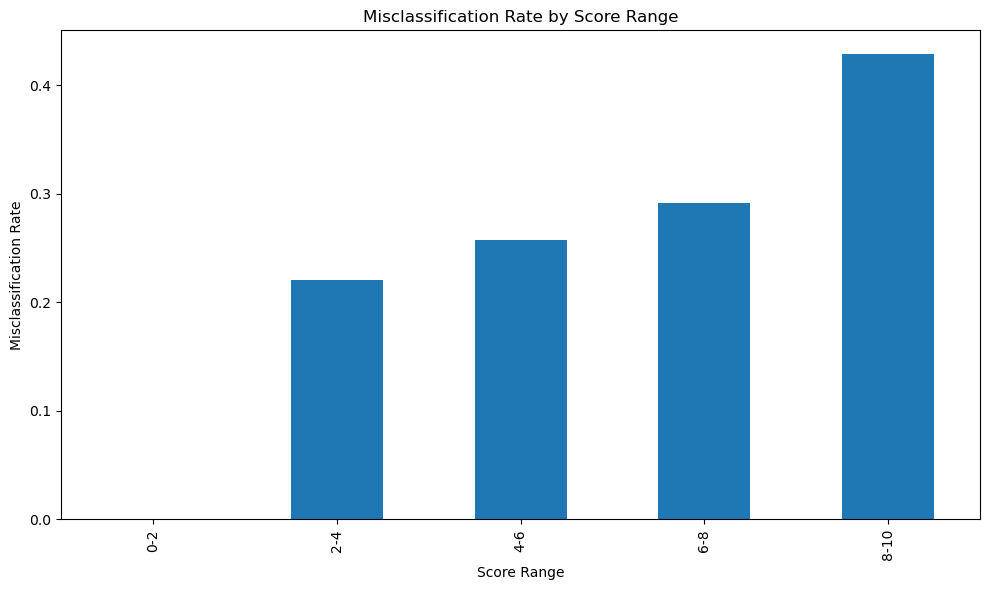

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming rf_classifier, vectorizer, X_test, y_test, y_pred, and merged_dataset are already defined

# Feature Importance Analysis
feature_names = vectorizer.get_feature_names_out().tolist() + ['quote_count', 'avg_quote_length']
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': rf_classifier.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# Word Cloud of Important Features
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
    dict(feature_importance.head(100).values)
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top 100 Important Features')
plt.show()

# Error Analysis
y_test_series = pd.Series(y_test, name='Actual')
y_pred_series = pd.Series(y_pred, name='Predicted')
results_df = pd.concat([y_test_series, y_pred_series], axis=1)

# Get indices of misclassified samples
misclassified = results_df[results_df['Actual'] != results_df['Predicted']].index

# Create a copy of the relevant data to avoid the SettingWithCopyWarning
misclassified_movies = merged_dataset.iloc[misclassified].copy()

# Display some information about misclassified movies
print("Sample of Misclassified Movies:")
print(misclassified_movies[['movie_title', 'average_combined_score', 'all_quotes']].head())

# Analyze misclassification by score ranges (adjusted for 1-10 scale)
misclassified_movies['score_range'] = pd.cut(misclassified_movies['average_combined_score'],
                                             bins=[0, 2, 4, 6, 8, 10],
                                             labels=['0-2', '2-4', '4-6', '6-8', '8-10'])

plt.figure(figsize=(10, 6))
misclassified_movies['score_range'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Misclassified Movies by Score Range')
plt.xlabel('Score Range')
plt.ylabel('Count of Misclassified Movies')
plt.tight_layout()
plt.show()

# Confusion Matrix with percentages
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Additional analysis: Distribution of all movies by score range
all_movies_score_range = pd.cut(merged_dataset['average_combined_score'],
                                bins=[0, 2, 4, 6, 8, 10],
                                labels=['0-2', '2-4', '4-6', '6-8', '8-10'])

plt.figure(figsize=(10, 6))
all_movies_score_range.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of All Movies by Score Range')
plt.xlabel('Score Range')
plt.ylabel('Count of Movies')
plt.tight_layout()
plt.show()

# Calculate misclassification rate for each score range
misclassification_rates = misclassified_movies['score_range'].value_counts() / all_movies_score_range.value_counts()
misclassification_rates = misclassification_rates.sort_index()

plt.figure(figsize=(10, 6))
misclassification_rates.plot(kind='bar')
plt.title('Misclassification Rate by Score Range')
plt.xlabel('Score Range')
plt.ylabel('Misclassification Rate')
plt.tight_layout()
plt.show()

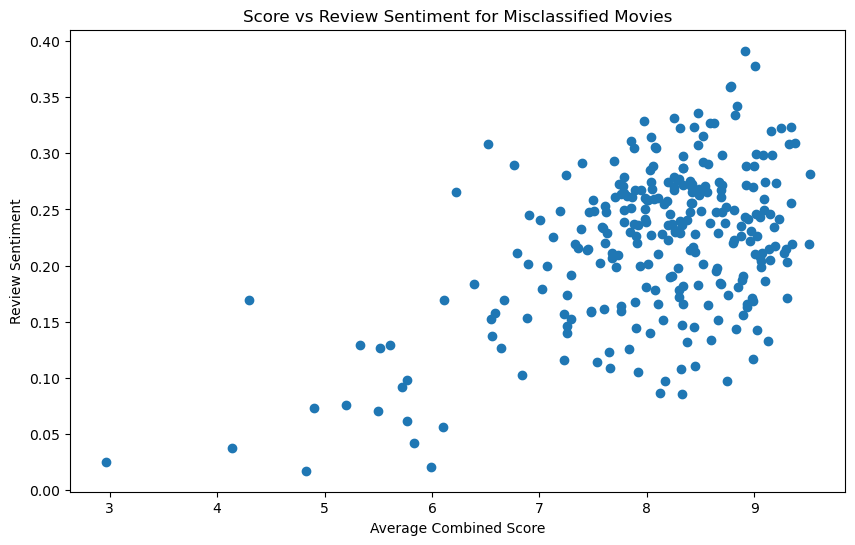

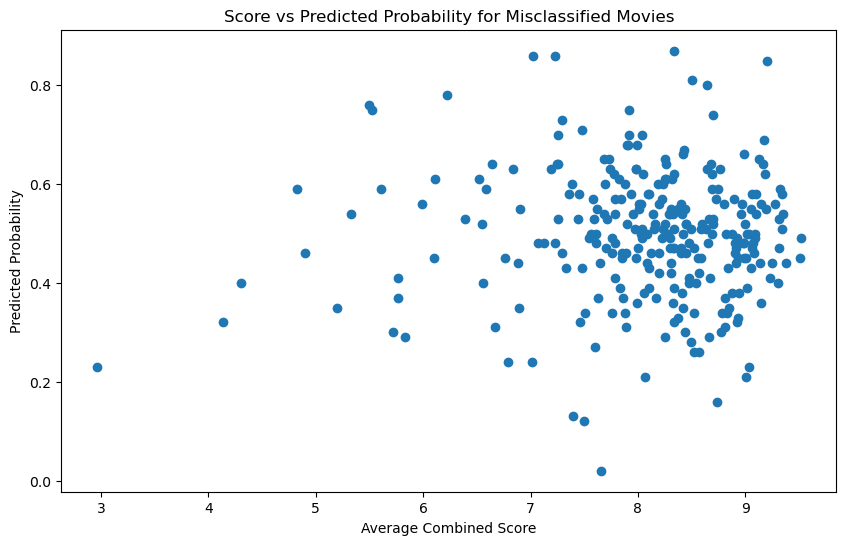

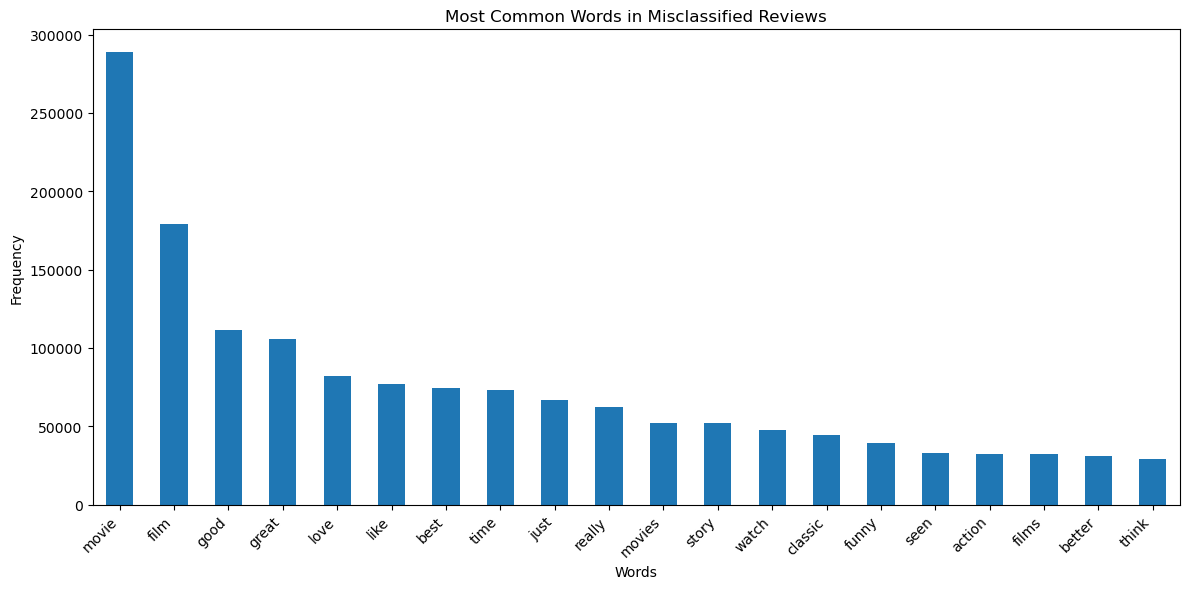

Correlation between score and sentiment: 0.5004831095655202

Average predicted probability: 0.49678832116788324
Median predicted probability: 0.5

High Score, Low Sentiment:
Empty DataFrame
Columns: [movie_title, average_combined_score, sentiment, all_quotes]
Index: []

Low Score, High Sentiment:
                            movie_title  average_combined_score  sentiment  \
264                The Angry Red Planet                    6.10   0.055878   
815                       Death Wish II                    5.77   0.098035   
846  Halloween III: Season of the Witch                    5.99   0.020613   
864                            Jaws III                    4.83   0.017343   
956                       Spies Like Us                    6.39   0.183709   

                                            all_quotes  
264  They don't make 'em like this anymore. It's ea...  
815  All the blood and none of the brain. And now, ...  
846  Points for trying something new, but the resul...  
864  

C:\Users\Marlissa\AppData\Local\Temp\ipykernel_152560\1656275675.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(misclassified_movies[misclassified_movies['average_combined_score'] > 7.5][misclassified_movies['sentiment'] < 0].head()[['movie_title', 'average_combined_score', 'sentiment', 'all_quotes']])
C:\Users\Marlissa\AppData\Local\Temp\ipykernel_152560\1656275675.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(misclassified_movies[misclassified_movies['average_combined_score'] < 6.5][misclassified_movies['sentiment'] > 0].head()[['movie_title', 'average_combined_score', 'sentiment', 'all_quotes']])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

# Assuming merged_dataset, rf_classifier, X_test, y_test, y_pred are already defined

# Create a DataFrame with test set indices, actual labels, and predicted labels
test_results = pd.DataFrame({
    'index': range(len(y_test)),
    'actual': y_test,
    'predicted': y_pred
})

# Identify misclassified instances
misclassified = test_results[test_results['actual'] != test_results['predicted']]

# Get the corresponding rows from X_test and merged_dataset
X_test_misclassified = X_test[misclassified['index']]
misclassified_movies = merged_dataset.iloc[misclassified['index']].copy()

# Add predicted probabilities
misclassified_movies['pred_proba'] = rf_classifier.predict_proba(X_test_misclassified)[:, 1]

# Function to get sentiment scores
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Add sentiment scores
misclassified_movies['sentiment'] = misclassified_movies['all_quotes'].apply(get_sentiment)

# Plot score vs sentiment
plt.figure(figsize=(10, 6))
plt.scatter(misclassified_movies['average_combined_score'], misclassified_movies['sentiment'])
plt.xlabel('Average Combined Score')
plt.ylabel('Review Sentiment')
plt.title('Score vs Review Sentiment for Misclassified Movies')
plt.show()

# Plot score vs predicted probability
plt.figure(figsize=(10, 6))
plt.scatter(misclassified_movies['average_combined_score'], misclassified_movies['pred_proba'])
plt.xlabel('Average Combined Score')
plt.ylabel('Predicted Probability')
plt.title('Score vs Predicted Probability for Misclassified Movies')
plt.show()

# Analyze most common words in misclassified reviews
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(misclassified_movies['all_quotes'].astype(str))
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())

plt.figure(figsize=(12, 6))
word_counts_df.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Most Common Words in Misclassified Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print some statistics
print("Correlation between score and sentiment:",
      misclassified_movies['average_combined_score'].corr(misclassified_movies['sentiment']))
print("\nAverage predicted probability:", misclassified_movies['pred_proba'].mean())
print("Median predicted probability:", misclassified_movies['pred_proba'].median())

# Print examples of high score, low sentiment and low score, high sentiment cases
print("\nHigh Score, Low Sentiment:")
print(misclassified_movies[misclassified_movies['average_combined_score'] > 7.5][misclassified_movies['sentiment'] < 0].head()[['movie_title', 'average_combined_score', 'sentiment', 'all_quotes']])

print("\nLow Score, High Sentiment:")
print(misclassified_movies[misclassified_movies['average_combined_score'] < 6.5][misclassified_movies['sentiment'] > 0].head()[['movie_title', 'average_combined_score', 'sentiment', 'all_quotes']])

Analyzing 10233 movies
Extracting features from reviews...


  0%|          | 1/10233 [00:00<20:58,  8.13it/s]

Processed 0 reviews


  1%|          | 101/10233 [00:20<13:02, 12.94it/s] 

Processed 100 reviews


  2%|▏         | 201/10233 [00:39<17:59,  9.30it/s]

Processed 200 reviews


  3%|▎         | 302/10233 [00:58<31:28,  5.26it/s]

Processed 300 reviews


  4%|▍         | 401/10233 [01:17<16:54,  9.69it/s]

Processed 400 reviews


  5%|▍         | 499/10233 [01:39<32:57,  4.92it/s]  

Processed 500 reviews


  6%|▌         | 601/10233 [02:05<37:52,  4.24it/s]  

Processed 600 reviews


  7%|▋         | 703/10233 [02:29<33:10,  4.79it/s]  

Processed 700 reviews


  8%|▊         | 801/10233 [02:54<28:21,  5.54it/s]  

Processed 800 reviews


  9%|▉         | 902/10233 [03:18<20:28,  7.60it/s]  

Processed 900 reviews


 10%|▉         | 1001/10233 [03:46<1:03:29,  2.42it/s]

Processed 1000 reviews


 11%|█         | 1101/10233 [04:14<44:21,  3.43it/s]  

Processed 1100 reviews


 12%|█▏        | 1201/10233 [04:39<33:36,  4.48it/s]  

Processed 1200 reviews


 13%|█▎        | 1300/10233 [05:09<45:19,  3.29it/s]  

Processed 1300 reviews


 14%|█▎        | 1401/10233 [05:34<36:52,  3.99it/s]  

Processed 1400 reviews


 15%|█▍        | 1501/10233 [06:01<57:50,  2.52it/s]  

Processed 1500 reviews


 16%|█▌        | 1603/10233 [06:31<32:14,  4.46it/s]  

Processed 1600 reviews


 17%|█▋        | 1700/10233 [06:59<35:16,  4.03it/s]  

Processed 1700 reviews


 18%|█▊        | 1801/10233 [07:31<1:27:00,  1.62it/s]

Processed 1800 reviews


 19%|█▊        | 1901/10233 [08:01<41:13,  3.37it/s]  

Processed 1900 reviews


 20%|█▉        | 2002/10233 [08:36<53:52,  2.55it/s]  

Processed 2000 reviews


 21%|██        | 2101/10233 [09:10<37:48,  3.58it/s]  

Processed 2100 reviews


 22%|██▏       | 2201/10233 [09:44<55:16,  2.42it/s]  

Processed 2200 reviews


 22%|██▏       | 2302/10233 [10:20<36:31,  3.62it/s]  

Processed 2300 reviews


 23%|██▎       | 2401/10233 [10:56<43:44,  2.98it/s]  

Processed 2400 reviews


 24%|██▍       | 2501/10233 [11:34<34:10,  3.77it/s]  

Processed 2500 reviews


 25%|██▌       | 2601/10233 [12:10<49:06,  2.59it/s]  

Processed 2600 reviews


 26%|██▋       | 2702/10233 [12:58<54:20,  2.31it/s]  

Processed 2700 reviews


 27%|██▋       | 2801/10233 [13:45<36:18,  3.41it/s]  

Processed 2800 reviews


 28%|██▊       | 2901/10233 [14:32<59:25,  2.06it/s]  

Processed 2900 reviews


 29%|██▉       | 3001/10233 [15:30<1:19:29,  1.52it/s]

Processed 3000 reviews


 30%|███       | 3101/10233 [16:27<1:13:01,  1.63it/s]

Processed 3100 reviews


 31%|███▏      | 3201/10233 [17:26<1:03:56,  1.83it/s]

Processed 3200 reviews


 32%|███▏      | 3301/10233 [18:30<1:27:43,  1.32it/s]

Processed 3300 reviews


 33%|███▎      | 3402/10233 [19:06<34:59,  3.25it/s]  

Processed 3400 reviews


 34%|███▍      | 3502/10233 [19:37<29:22,  3.82it/s]  

Processed 3500 reviews


 35%|███▌      | 3601/10233 [20:06<26:09,  4.23it/s]  

Processed 3600 reviews


 36%|███▌      | 3702/10233 [20:28<25:42,  4.23it/s]

Processed 3700 reviews


 37%|███▋      | 3801/10233 [20:50<12:34,  8.52it/s]

Processed 3800 reviews


 38%|███▊      | 3902/10233 [21:06<13:39,  7.73it/s]

Processed 3900 reviews


 39%|███▉      | 4003/10233 [21:23<14:16,  7.27it/s]

Processed 4000 reviews


 40%|████      | 4103/10233 [21:35<09:57, 10.26it/s]

Processed 4100 reviews


 41%|████      | 4202/10233 [21:48<11:52,  8.46it/s]

Processed 4200 reviews


 42%|████▏     | 4304/10233 [21:59<06:40, 14.80it/s]

Processed 4300 reviews


 43%|████▎     | 4402/10233 [22:08<08:11, 11.87it/s]

Processed 4400 reviews


 44%|████▍     | 4503/10233 [22:20<16:11,  5.90it/s]

Processed 4500 reviews


 45%|████▍     | 4602/10233 [22:28<06:43, 13.95it/s]

Processed 4600 reviews


 46%|████▌     | 4704/10233 [22:37<08:07, 11.34it/s]

Processed 4700 reviews


 47%|████▋     | 4804/10233 [22:45<05:38, 16.05it/s]

Processed 4800 reviews


 48%|████▊     | 4905/10233 [22:51<05:06, 17.41it/s]

Processed 4900 reviews


 49%|████▉     | 5001/10233 [22:58<06:27, 13.51it/s]

Processed 5000 reviews


 50%|████▉     | 5107/10233 [23:05<03:08, 27.15it/s]

Processed 5100 reviews


 51%|█████     | 5204/10233 [23:10<03:18, 25.30it/s]

Processed 5200 reviews


 52%|█████▏    | 5304/10233 [23:17<05:38, 14.55it/s]

Processed 5300 reviews


 53%|█████▎    | 5407/10233 [23:23<03:31, 22.85it/s]

Processed 5400 reviews


 54%|█████▍    | 5506/10233 [23:30<05:15, 14.98it/s]

Processed 5500 reviews


 55%|█████▍    | 5604/10233 [23:36<05:11, 14.86it/s]

Processed 5600 reviews


 56%|█████▌    | 5706/10233 [23:42<03:56, 19.17it/s]

Processed 5700 reviews


 57%|█████▋    | 5804/10233 [23:47<02:45, 26.83it/s]

Processed 5800 reviews


 58%|█████▊    | 5908/10233 [23:53<02:42, 26.65it/s]

Processed 5900 reviews


 59%|█████▊    | 6006/10233 [23:59<02:57, 23.78it/s]

Processed 6000 reviews


 60%|█████▉    | 6105/10233 [24:05<02:32, 27.15it/s]

Processed 6100 reviews


 61%|██████    | 6207/10233 [24:09<01:46, 37.63it/s]

Processed 6200 reviews


 62%|██████▏   | 6304/10233 [24:14<02:20, 28.01it/s]

Processed 6300 reviews


 63%|██████▎   | 6403/10233 [24:18<02:18, 27.57it/s]

Processed 6400 reviews


 64%|██████▎   | 6506/10233 [24:22<01:46, 34.90it/s]

Processed 6500 reviews


 65%|██████▍   | 6605/10233 [24:26<01:58, 30.65it/s]

Processed 6600 reviews


 65%|██████▌   | 6701/10233 [24:29<01:11, 49.14it/s]

Processed 6700 reviews


 66%|██████▋   | 6801/10233 [24:32<02:18, 24.70it/s]

Processed 6800 reviews


 67%|██████▋   | 6907/10233 [24:35<01:32, 35.91it/s]

Processed 6900 reviews


 69%|██████▊   | 7010/10233 [24:38<01:28, 36.30it/s]

Processed 7000 reviews


 69%|██████▉   | 7108/10233 [24:41<01:24, 36.77it/s]

Processed 7100 reviews


 70%|███████   | 7207/10233 [24:44<01:49, 27.58it/s]

Processed 7200 reviews


 71%|███████▏  | 7306/10233 [24:45<00:58, 49.79it/s]

Processed 7300 reviews


 72%|███████▏  | 7410/10233 [24:48<01:00, 46.50it/s]

Processed 7400 reviews


 73%|███████▎  | 7505/10233 [24:51<01:24, 32.36it/s]

Processed 7500 reviews


 74%|███████▍  | 7609/10233 [24:53<00:56, 46.11it/s]

Processed 7600 reviews


 75%|███████▌  | 7707/10233 [24:56<01:13, 34.37it/s]

Processed 7700 reviews


 76%|███████▋  | 7813/10233 [24:58<00:38, 62.38it/s]

Processed 7800 reviews


 77%|███████▋  | 7913/10233 [25:00<00:39, 58.99it/s]

Processed 7900 reviews


 78%|███████▊  | 7998/10233 [25:01<00:34, 64.75it/s]

Processed 8000 reviews


 79%|███████▉  | 8110/10233 [25:04<00:49, 42.97it/s]

Processed 8100 reviews


 80%|████████  | 8209/10233 [25:06<00:37, 53.34it/s]

Processed 8200 reviews


 81%|████████  | 8309/10233 [25:08<00:49, 39.20it/s]

Processed 8300 reviews


 82%|████████▏ | 8416/10233 [25:10<00:31, 56.87it/s]

Processed 8400 reviews


 83%|████████▎ | 8516/10233 [25:11<00:29, 58.15it/s]

Processed 8500 reviews


 84%|████████▍ | 8606/10233 [25:13<00:25, 63.57it/s]

Processed 8600 reviews


 85%|████████▌ | 8723/10233 [25:15<00:16, 92.33it/s]

Processed 8700 reviews


 86%|████████▌ | 8811/10233 [25:16<00:18, 78.98it/s]

Processed 8800 reviews


 87%|████████▋ | 8908/10233 [25:17<00:20, 64.44it/s]

Processed 8900 reviews


 88%|████████▊ | 9011/10233 [25:19<00:15, 78.25it/s]

Processed 9000 reviews


 89%|████████▉ | 9115/10233 [25:20<00:16, 68.89it/s]

Processed 9100 reviews


 90%|█████████ | 9217/10233 [25:22<00:14, 70.69it/s]

Processed 9200 reviews


 91%|█████████ | 9314/10233 [25:23<00:09, 92.38it/s]

Processed 9300 reviews


 92%|█████████▏| 9415/10233 [25:24<00:11, 74.22it/s]

Processed 9400 reviews


 93%|█████████▎| 9512/10233 [25:25<00:08, 86.28it/s]

Processed 9500 reviews


 94%|█████████▍| 9615/10233 [25:26<00:06, 101.54it/s]

Processed 9600 reviews


 95%|█████████▍| 9721/10233 [25:27<00:04, 108.87it/s]

Processed 9700 reviews


 96%|█████████▌| 9799/10233 [25:28<00:05, 85.74it/s] 

Processed 9800 reviews


 97%|█████████▋| 9930/10233 [25:30<00:02, 129.76it/s]

Processed 9900 reviews


 98%|█████████▊| 10013/10233 [25:30<00:01, 171.74it/s]

Processed 10000 reviews


 99%|█████████▉| 10126/10233 [25:31<00:00, 166.16it/s]

Processed 10100 reviews


100%|██████████| 10233/10233 [25:32<00:00,  6.68it/s] 

Processed 10200 reviews


Analyzing correlation...
Correlation with movie quality:
is_good            1.000000
sentiment          0.398828
avg_word_length    0.188073
word_count         0.152365
subjectivity       0.030164
Name: is_good, dtype: float64


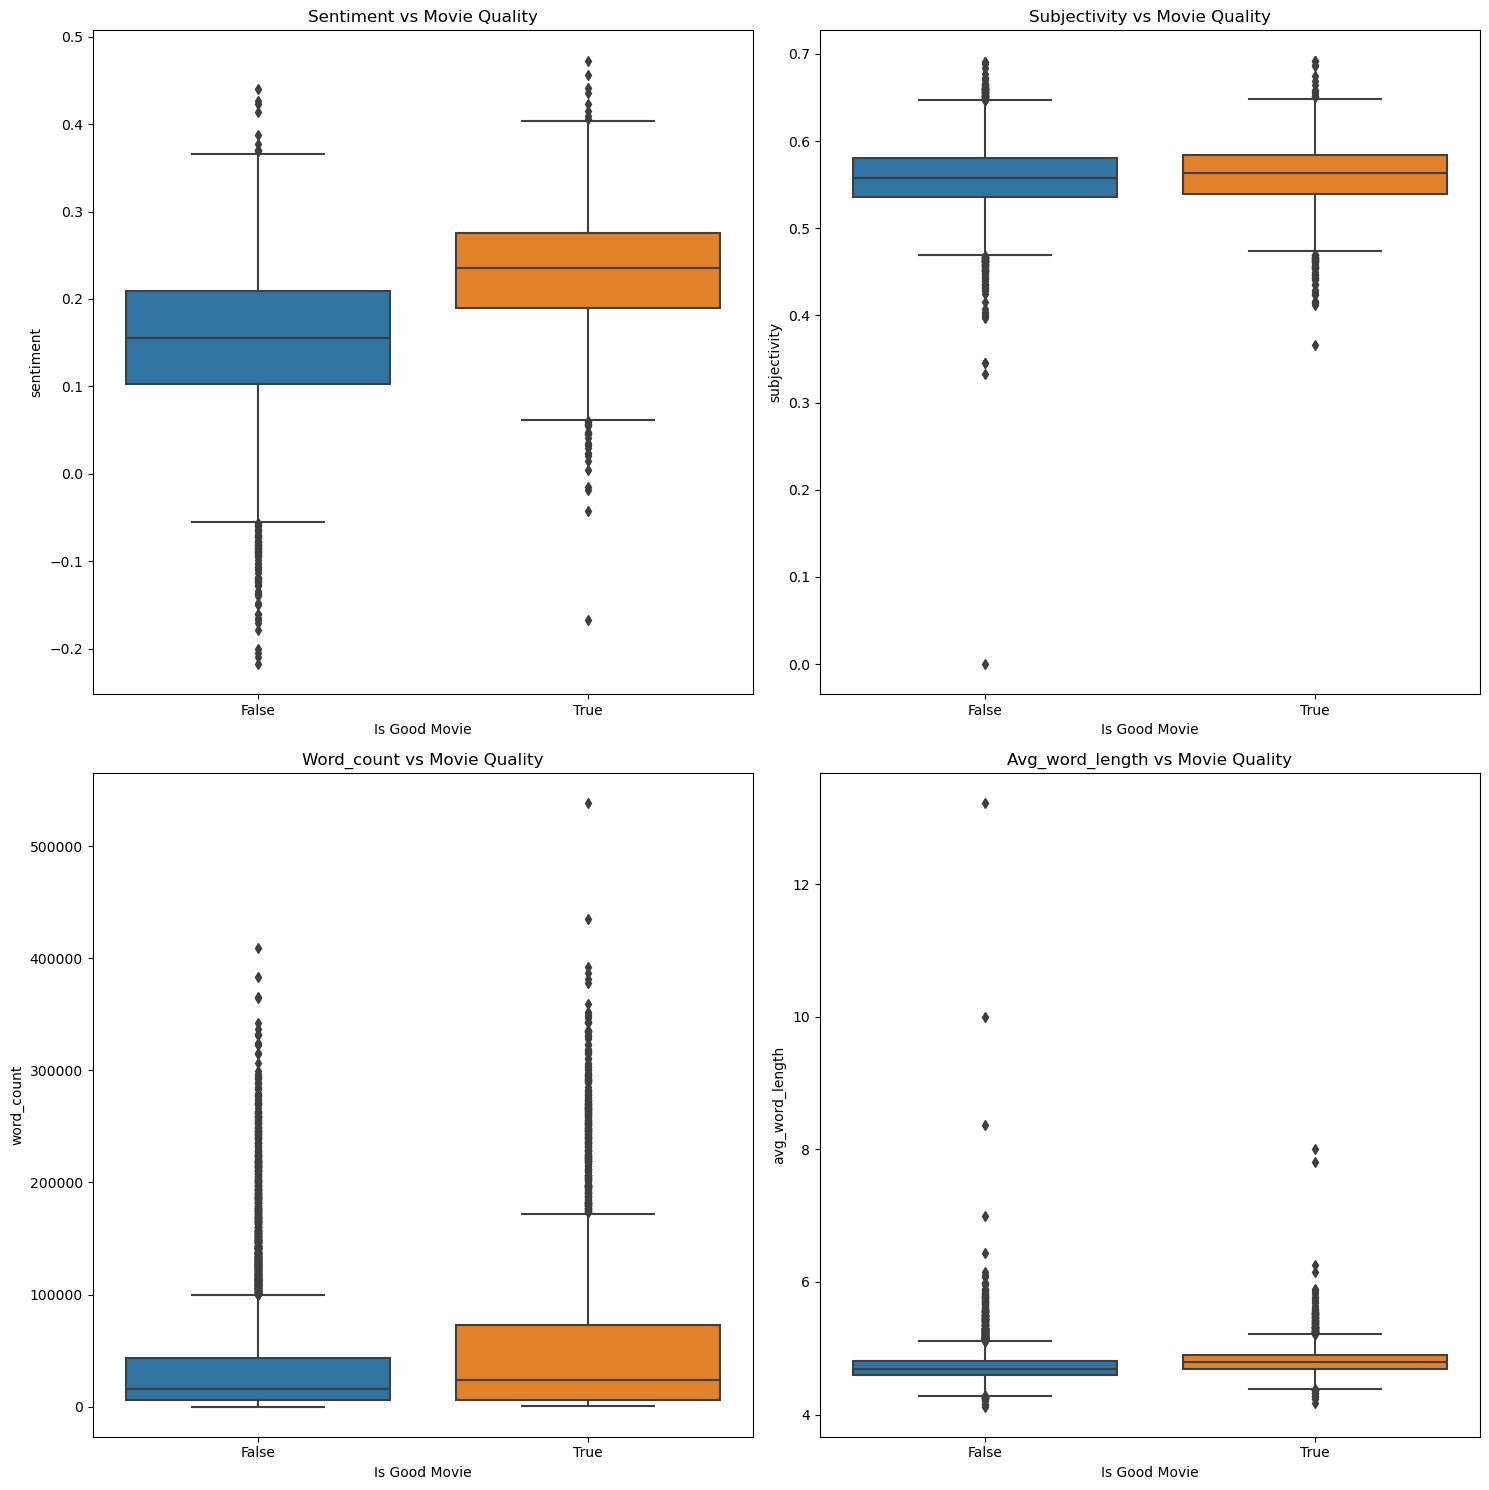

Analyzing word frequencies...

Top 20 words in good movies:
movie         1979842
film          1425055
great          810589
good           710348
best           618407
like           540820
love           509910
story          504823
time           501595
just           479158
really         462314
movies         370178
watch          322666
classic        275790
films          262326
seen           256107
amazing        224658
way            215159
characters     209622
funny          208027
dtype: int64

Top 20 words in not-so-good movies:
movie     4358387
film      2039632
good      2013081
like      1266687
great     1240741
really    1078109
just      1050280
love       940627
story      830625
funny      805344
time       690295
best       649754
movies     637966
watch      633433
better     614151
bad        551364
action     479550
pretty     463560
think      441741
don        438255
dtype: int64

Top 20 words more common in good movies:
film            0.008197
best      

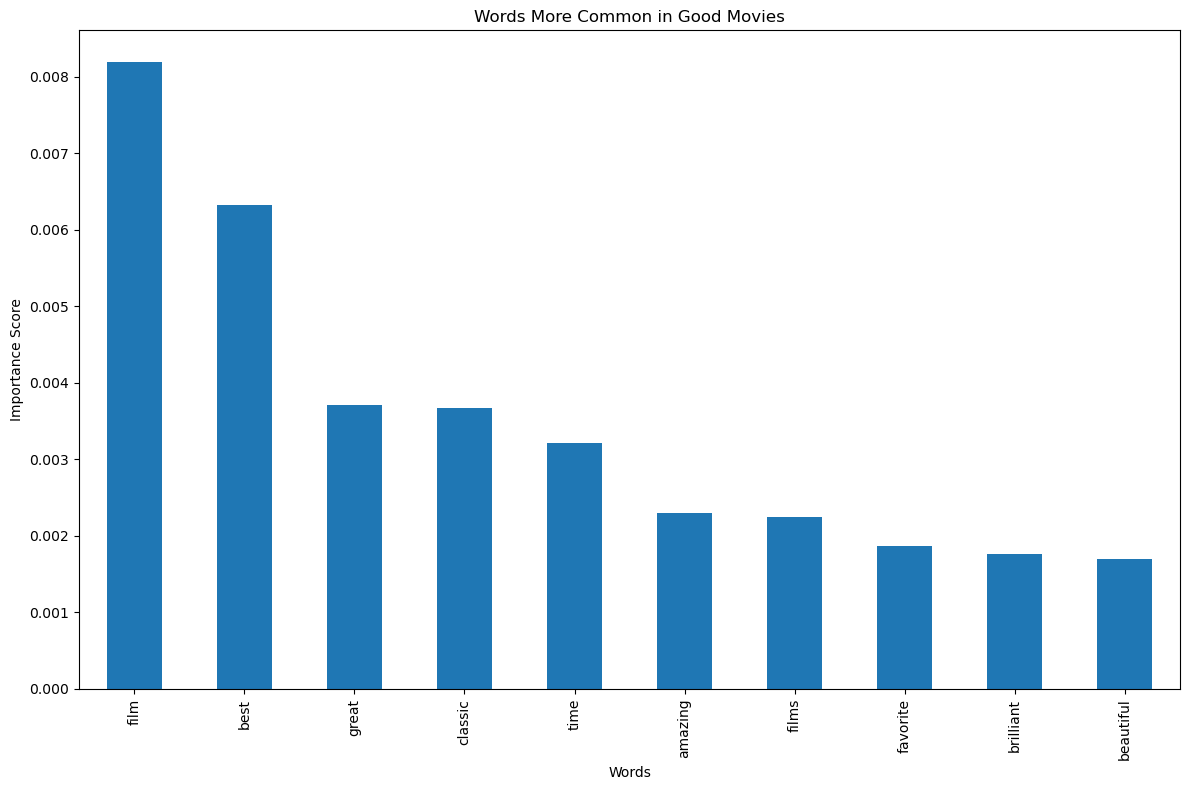

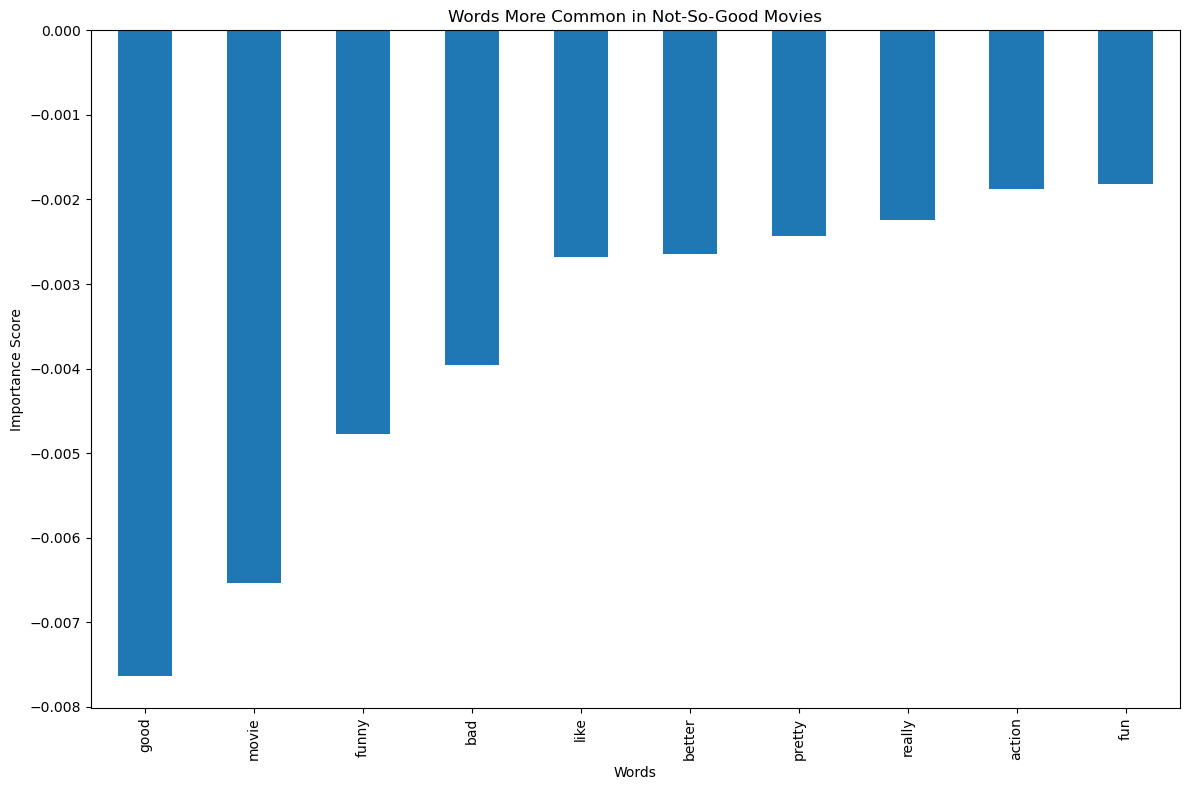

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Assuming merged_dataset is already loaded

print(f"Analyzing {len(merged_dataset)} movies")

# Define 'good' movies as those with ratings above the 75th percentile
rating_threshold = merged_dataset['average_combined_score'].quantile(0.75)
merged_dataset['is_good'] = merged_dataset['average_combined_score'] >= rating_threshold

def extract_features(text):
    text = str(text)
    blob = TextBlob(text)
    return pd.Series({
        'sentiment': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'word_count': len(text.split()),
        'avg_word_length': sum(len(word) for word in text.split()) / len(text.split()) if text else 0,
    })

print("Extracting features from reviews...")
# Extract features from reviews with manual progress updates
review_features = []
for i, text in enumerate(tqdm(merged_dataset['all_quotes'])):
    review_features.append(extract_features(text))
    if i % 100 == 0:
        print(f"Processed {i} reviews")

review_features = pd.DataFrame(review_features)
merged_dataset = pd.concat([merged_dataset, review_features], axis=1)

print("Analyzing correlation...")
# Analyze correlation between features and movie quality
correlation = merged_dataset[['is_good', 'sentiment', 'subjectivity', 'word_count', 'avg_word_length']].corr()['is_good'].sort_values(ascending=False)
print("Correlation with movie quality:")
print(correlation)

# Visualize the distribution of features for good vs. not good movies
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i, feature in enumerate(['sentiment', 'subjectivity', 'word_count', 'avg_word_length']):
    sns.boxplot(x='is_good', y=feature, data=merged_dataset, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{feature.capitalize()} vs Movie Quality')
    axes[i//2, i%2].set_xlabel('Is Good Movie')
plt.tight_layout()
plt.show()

print("Analyzing word frequencies...")
# Analyze most common words in good vs. not good movies
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
word_counts = vectorizer.fit_transform(merged_dataset['all_quotes'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())

good_movies_words = word_counts_df[merged_dataset['is_good']].sum().sort_values(ascending=False)
bad_movies_words = word_counts_df[~merged_dataset['is_good']].sum().sort_values(ascending=False)

print("\nTop 20 words in good movies:")
print(good_movies_words.head(20))

print("\nTop 20 words in not-so-good movies:")
print(bad_movies_words.head(20))

# Calculate word importance score (difference in frequency between good and not-good movies)
total_good_words = good_movies_words.sum()
total_bad_words = bad_movies_words.sum()
word_importance = (good_movies_words / total_good_words) - (bad_movies_words / total_bad_words)
word_importance = word_importance.sort_values(ascending=False)

print("\nTop 20 words more common in good movies:")
print(word_importance.head(20))

print("\nTop 20 words more common in not-so-good movies:")
print(word_importance.tail(20).sort_values())

# Visualize top distinguishing words
plt.figure(figsize=(12, 8))
word_importance.head(10).plot(kind='bar')
plt.title('Words More Common in Good Movies')
plt.xlabel('Words')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
word_importance.tail(10).sort_values().plot(kind='bar')
plt.title('Words More Common in Not-So-Good Movies')
plt.xlabel('Words')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

Shape of the dataset: (10233, 23)

Columns in the dataset:
Index(['movie_id', 'movie_year', 'movie_title', 'rating', 'original_language',
       'runtime_in_minutes', 'critic_score', 'user_score',
       'average_combined_score', 'critic_review_count', 'user_review_count',
       'all_quotes', 'cleaned_quotes', 'quote_count', 'avg_quote_length',
       'is_good', 'sentiment', 'subjectivity', 'word_count', 'avg_word_length',
       'genres', 'genre_count', 'runtime_bin'],
      dtype='object')

Average ratings by language (for languages with more than 20 movies):
                       mean  count
original_language                 
Japanese           8.338352    176
Danish             8.324545     22
Unknown            8.250870     23
Korean             8.185521     96
Hindi              8.172095    105
French             8.118814    177
German             8.078182     55
Russian            8.045455     22
Italian            7.997917     48
Swedish            7.931739     23
Spanish    

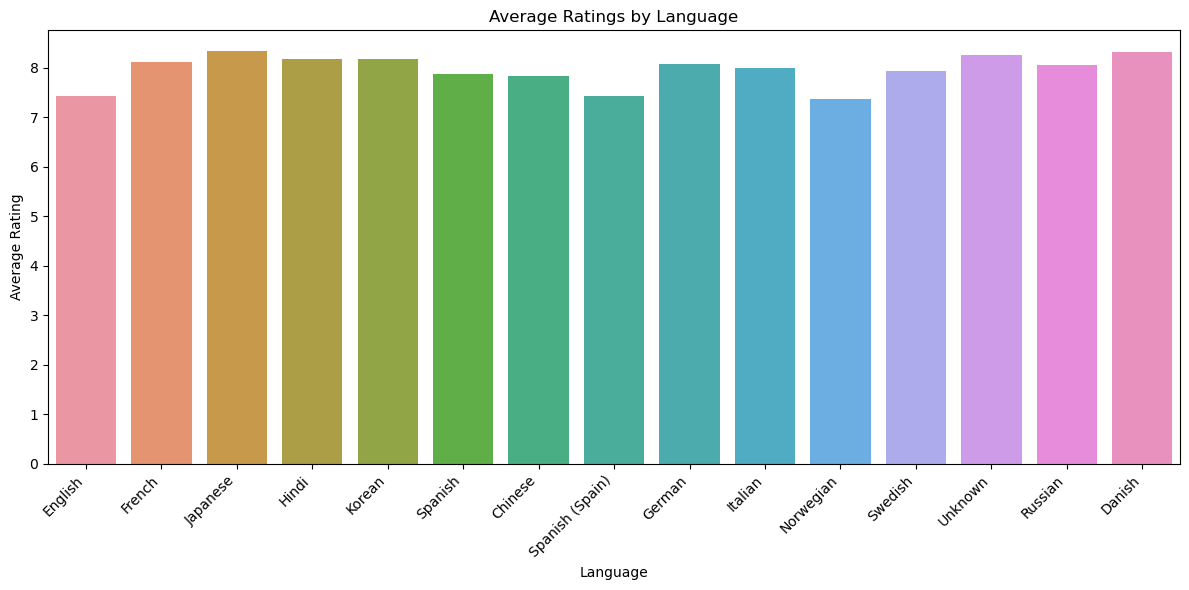

C:\Users\Marlissa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


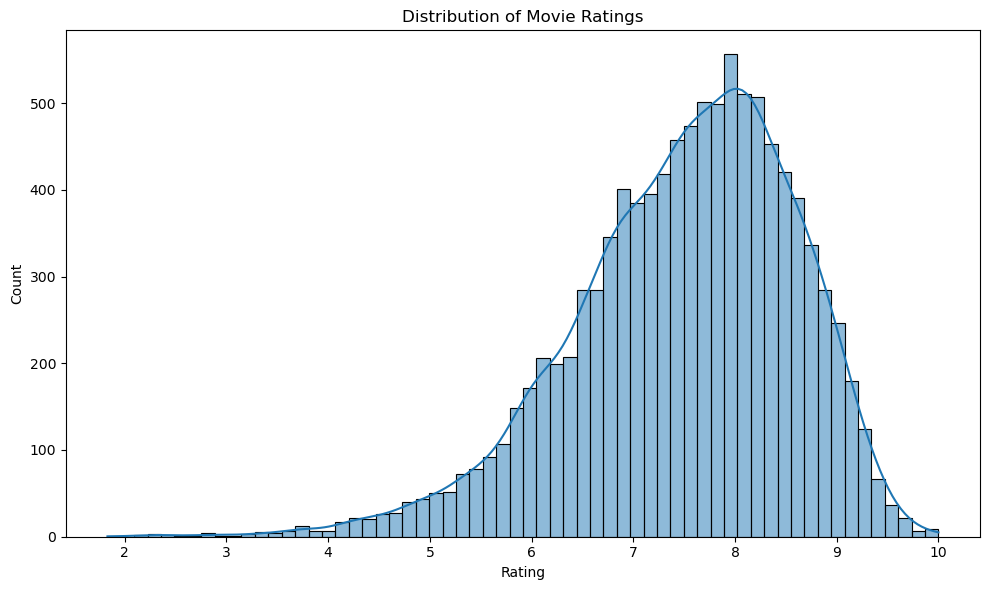

C:\Users\Marlissa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Summary Statistics of Ratings:
count    10233.000000
mean         7.496486
std          1.095826
min          1.830000
25%          6.840000
50%          7.630000
75%          8.290000
max         10.000000
Name: average_combined_score, dtype: float64

Top 20 Highest Rated Movies:
                                             movie_title  \
6334                                            Sex Doll   
7065                                         Sex Weather   
9202                                     About Him & Her   
9823                   Keith Robinson: Different Strokes   
9861                               Living With Leopards    
10023                                       The American   
7287                            Who Killed Captain Alex?   
9929                                Gaga Chromatica Ball   
10037            The Real Bros of Simi Valley: The Movie   
6651   Daughters of the Sexual Revolution: The Untold...   
8353              Civil War (Or, Who Do We Think We Are) 

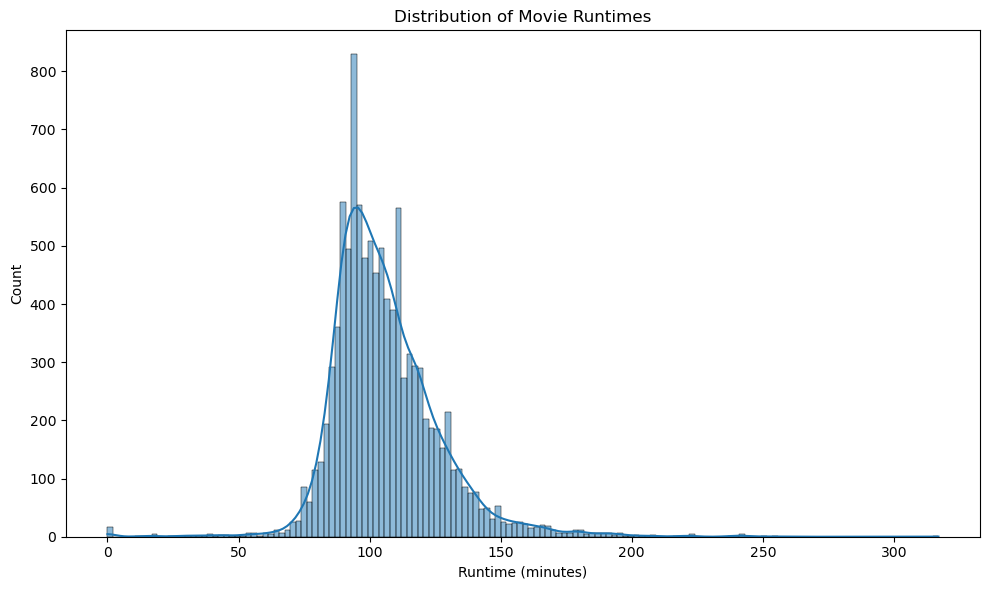


Correlation between runtime and rating: 0.226


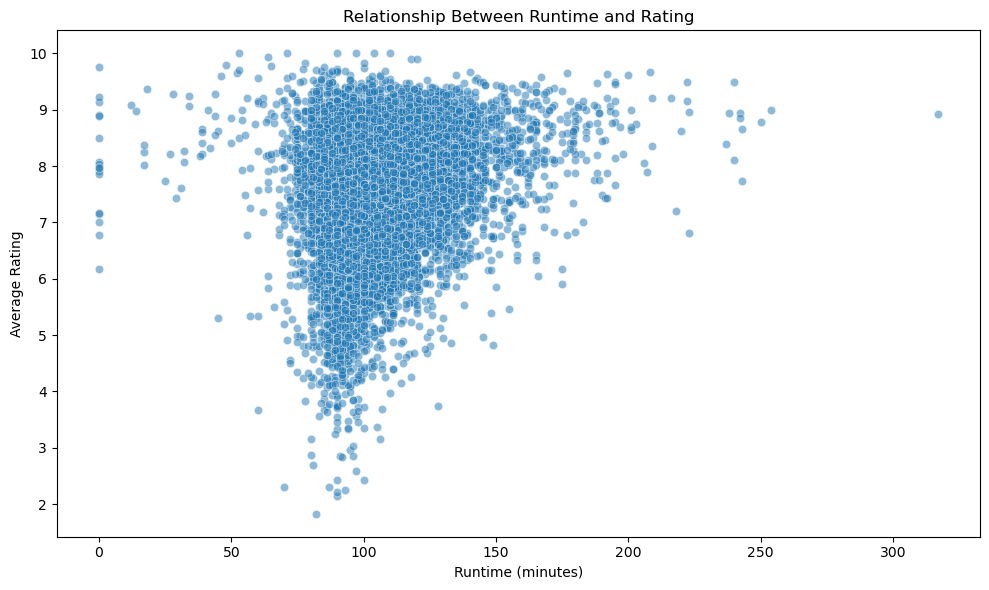

C:\Users\Marlissa\AppData\Local\Temp\ipykernel_152560\3288174699.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_ratings = merged_dataset.groupby('runtime_bin')['average_combined_score'].mean().sort_values(ascending=False)
C:\Users\Marlissa\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


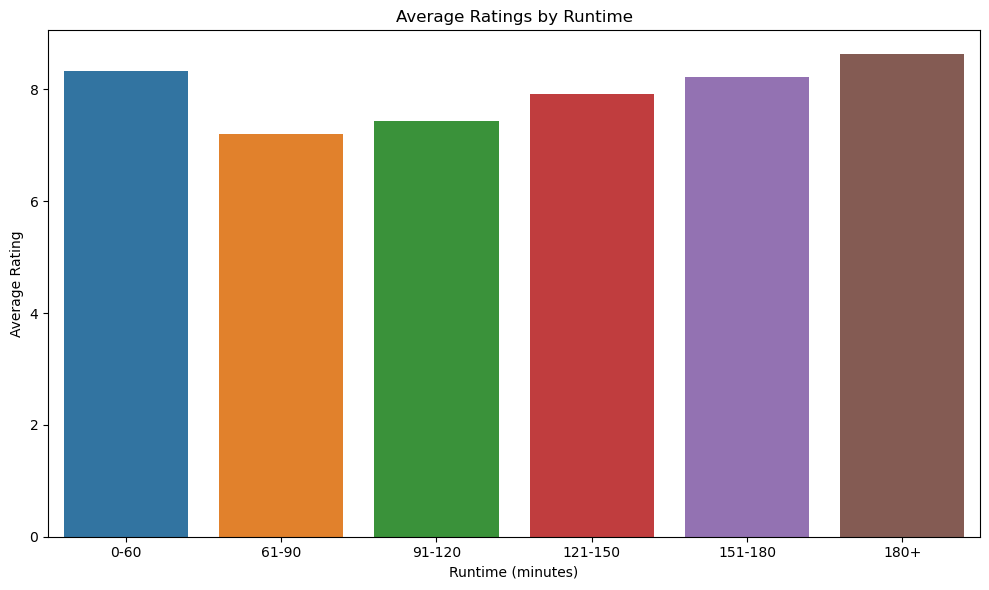


Average runtime by language (for languages with more than 20 movies):
                   runtime_in_minutes  count
original_language                           
Hindi                      147.533333    105
Russian                    124.000000     22
Korean                     120.218750     96
Chinese                    115.766667     60
Swedish                    113.304348     23
Italian                    112.958333     48
Japanese                   110.727273    176
Danish                     110.681818     22
German                     108.909091     55
French                     106.288136    177
Spanish                    105.671429     70
English                    105.025937   9099
Spanish (Spain)            102.701754     57
Norwegian                  102.333333     24
Unknown                     93.782609     23


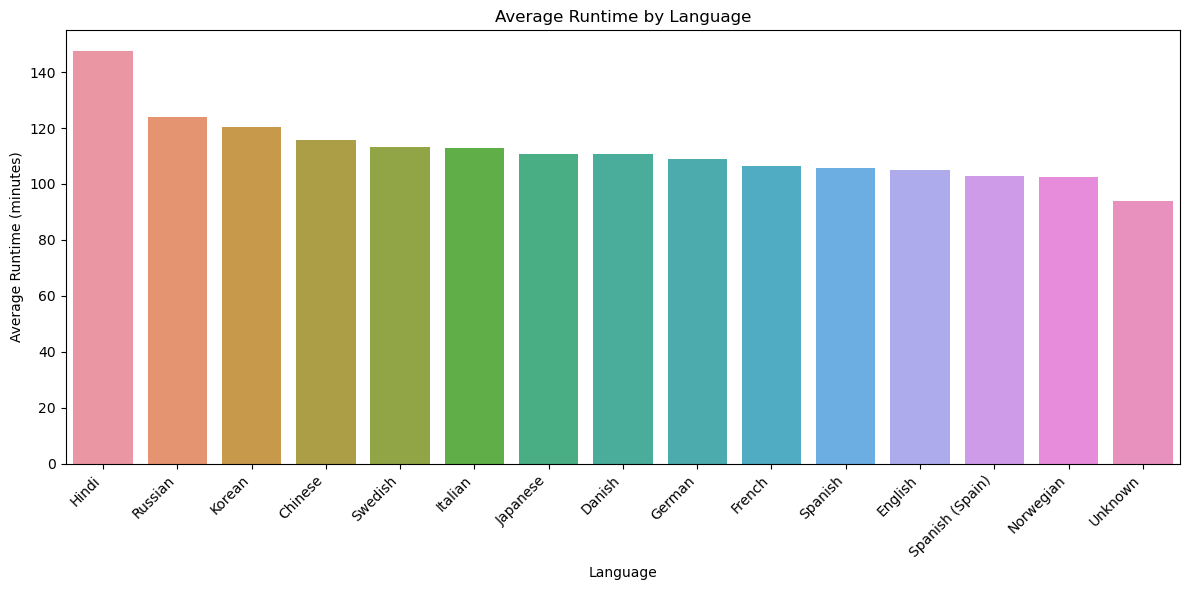

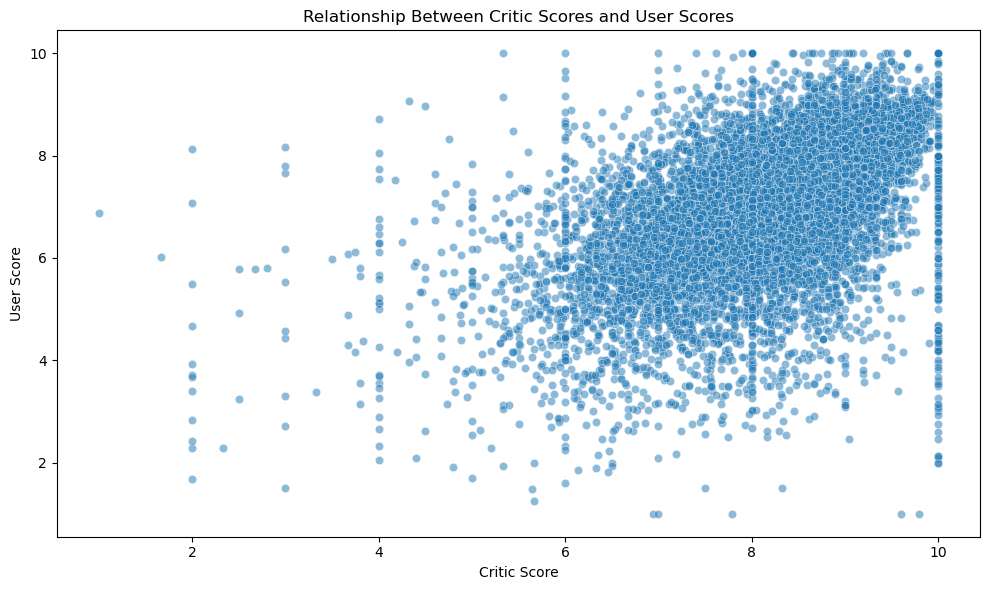


Correlation between critic scores and user scores: 0.505

Average difference between critic and user scores (critic - user): 1.161


C:\Users\Marlissa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


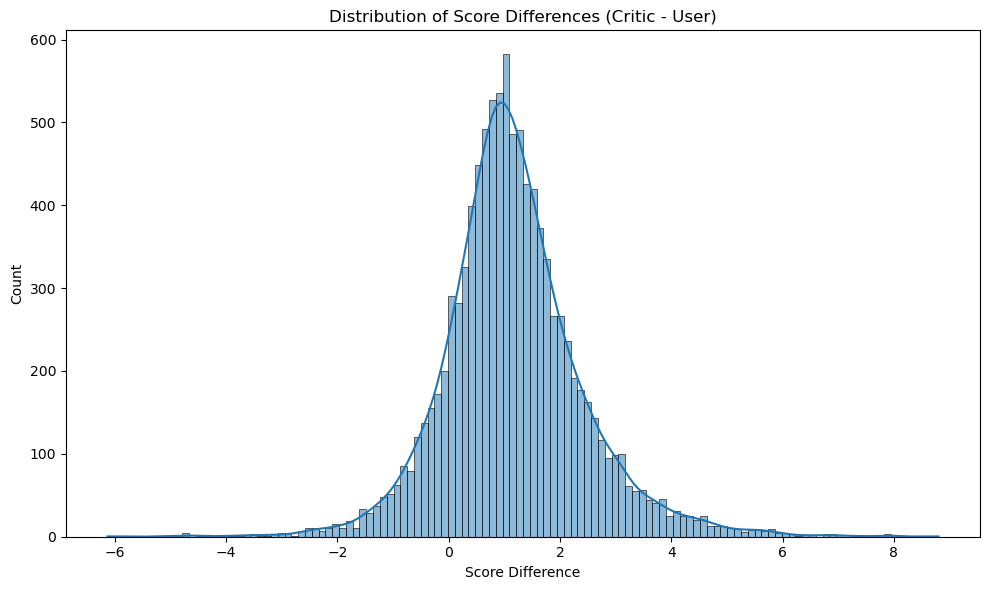

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_dataset is already loaded

print("Shape of the dataset:", merged_dataset.shape)
print("\nColumns in the dataset:")
print(merged_dataset.columns)

# Analyze average ratings by language
language_ratings = merged_dataset.groupby('original_language')['average_combined_score'].agg(['mean', 'count']).sort_values('count', ascending=False)
language_ratings = language_ratings[language_ratings['count'] > 20]  # Filter languages with more than 20 movies

print("\nAverage ratings by language (for languages with more than 20 movies):")
print(language_ratings.sort_values('mean', ascending=False))

# Plot average ratings by language
plt.figure(figsize=(12, 6))
sns.barplot(x=language_ratings.index, y='mean', data=language_ratings)
plt.title('Average Ratings by Language')
plt.xlabel('Language')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_dataset['average_combined_score'], kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print summary statistics of ratings
print("\nSummary Statistics of Ratings:")
print(merged_dataset['average_combined_score'].describe())

# Analyze top-rated movies
top_movies = merged_dataset.nlargest(20, 'average_combined_score')[['movie_title', 'average_combined_score', 'original_language', 'runtime_in_minutes']]
print("\nTop 20 Highest Rated Movies:")
print(top_movies)

# Analyze lowest-rated movies
bottom_movies = merged_dataset.nsmallest(20, 'average_combined_score')[['movie_title', 'average_combined_score', 'original_language', 'runtime_in_minutes']]
print("\nTop 20 Lowest Rated Movies:")
print(bottom_movies)

# Analyze runtime
print("\nSummary Statistics of Runtime (in minutes):")
print(merged_dataset['runtime_in_minutes'].describe())

# Plot distribution of runtime
plt.figure(figsize=(10, 6))
sns.histplot(merged_dataset['runtime_in_minutes'], kde=True)
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate correlation between runtime and rating
runtime_correlation = merged_dataset['runtime_in_minutes'].corr(merged_dataset['average_combined_score'])
print(f"\nCorrelation between runtime and rating: {runtime_correlation:.3f}")

# Plot relationship between runtime and rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='runtime_in_minutes', y='average_combined_score', data=merged_dataset, alpha=0.5)
plt.title('Relationship Between Runtime and Rating')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

# Analyze average rating by runtime bins
merged_dataset['runtime_bin'] = pd.cut(merged_dataset['runtime_in_minutes'],
                                       bins=[0, 60, 90, 120, 150, 180, float('inf')],
                                       labels=['0-60', '61-90', '91-120', '121-150', '151-180', '180+'])
runtime_ratings = merged_dataset.groupby('runtime_bin')['average_combined_score'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=runtime_ratings.index, y=runtime_ratings.values)
plt.title('Average Ratings by Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_dataset is already loaded and previous analyses have been run

# Analyze average runtime by language
language_runtimes = merged_dataset.groupby('original_language').agg({
    'runtime_in_minutes': 'mean',
    'movie_id': 'count'
}).rename(columns={'movie_id': 'count'})

language_runtimes = language_runtimes[language_runtimes['count'] > 20].sort_values('runtime_in_minutes', ascending=False)

print("\nAverage runtime by language (for languages with more than 20 movies):")
print(language_runtimes)

# Plot average runtime by language
plt.figure(figsize=(12, 6))
sns.barplot(x=language_runtimes.index, y='runtime_in_minutes', data=language_runtimes)
plt.title('Average Runtime by Language')
plt.xlabel('Language')
plt.ylabel('Average Runtime (minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze the relationship between critic scores and user scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x='critic_score', y='user_score', data=merged_dataset, alpha=0.5)
plt.title('Relationship Between Critic Scores and User Scores')
plt.xlabel('Critic Score')
plt.ylabel('User Score')
plt.tight_layout()
plt.show()

critic_user_correlation = merged_dataset['critic_score'].corr(merged_dataset['user_score'])
print(f"\nCorrelation between critic scores and user scores: {critic_user_correlation:.3f}")

# Analyze which score (critic or user) is generally higher
merged_dataset['score_difference'] = merged_dataset['critic_score'] - merged_dataset['user_score']
average_difference = merged_dataset['score_difference'].mean()
print(f"\nAverage difference between critic and user scores (critic - user): {average_difference:.3f}")

plt.figure(figsize=(10, 6))
sns.histplot(merged_dataset['score_difference'], kde=True)
plt.title('Distribution of Score Differences (Critic - User)')
plt.xlabel('Score Difference')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



To make a "good" movie based on this data:

Consider making it in a non-English language, particularly Japanese, Korean, or Hindi.
Aim for a runtime of around 2 hours or slightly more.
Focus on original storytelling rather than sequels or remakes.
Invest in production quality.
Pay attention to both critical reception and audience response, as they can differ.
Don't shy away from niche topics or genres, as these can also produce highly-rated films.


Inspecting data for Critic Score:
Columns in the DataFrame:
Index(['movie_id', 'movie_year', 'movie_title', 'rating', 'original_language',
       'runtime_in_minutes', 'critic_score', 'user_score',
       'average_combined_score', 'critic_review_count', 'user_review_count',
       'all_quotes', 'cleaned_quotes', 'quote_count', 'avg_quote_length',
       'is_good', 'sentiment', 'subjectivity', 'word_count', 'avg_word_length',
       'genres', 'genre_count', 'runtime_bin', 'score_difference'],
      dtype='object')

Data types:
movie_id                    object
movie_year                   int64
movie_title                 object
rating                      object
original_language           object
runtime_in_minutes           int64
critic_score               float64
user_score                 float64
average_combined_score     float64
critic_review_count          int64
user_review_count            int64
all_quotes                  object
cleaned_quotes              object
quote_count 

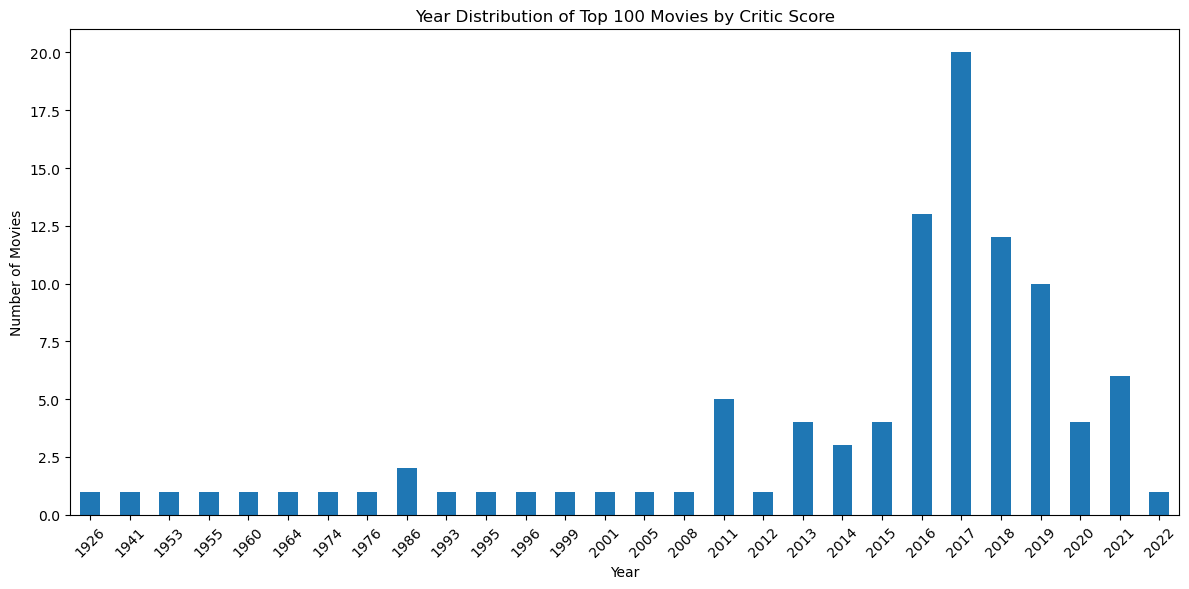


Average runtime: 104.71 minutes

Analyzing Top 100 Movies by User Score:

Language distribution:
original_language
English       83
Japanese       5
Hindi          2
Unknown        2
Spanish        2
Estonian       1
Swahili        1
Arabic         1
Hebrew         1
French         1
Portuguese     1
Name: count, dtype: int64

Year distribution:
movie_year
2017     2
2018     5
2019     6
2020     6
2021     4
2022     7
2023    29
2024    41
Name: count, dtype: int64


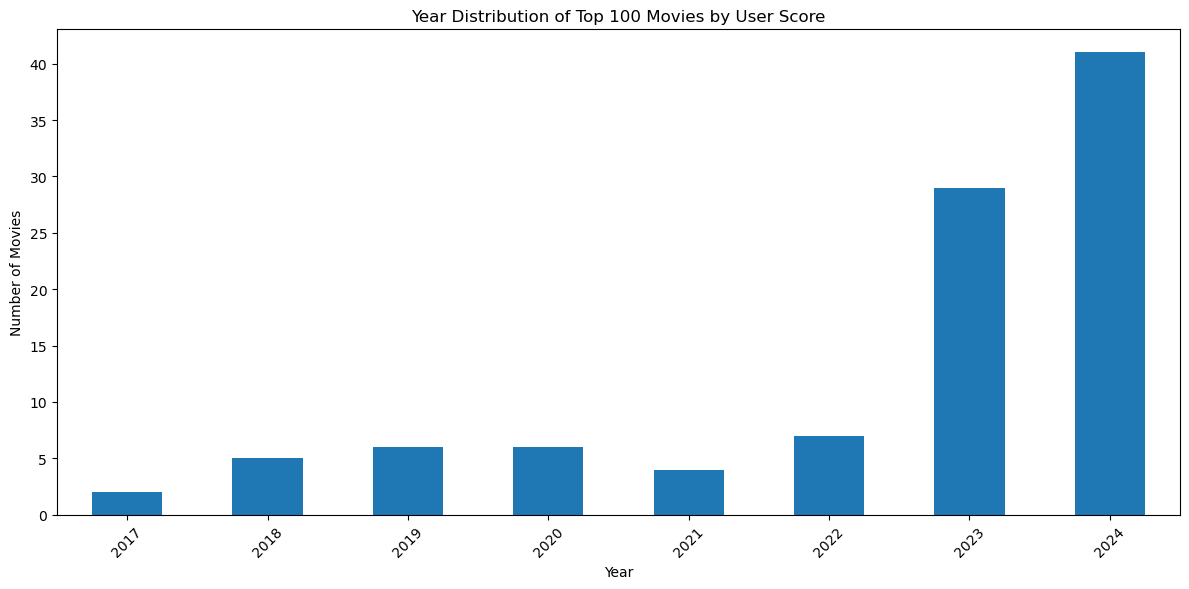


Average runtime: 97.28 minutes

Analyzing Top 100 Movies by Combined Score:

Language distribution:
original_language
English       73
Japanese       8
Unknown        4
Hindi          3
French         2
Italian        2
German         2
Swahili        1
Spanish        1
Belarusian     1
Chinese        1
Swedish        1
Arabic         1
Name: count, dtype: int64

Year distribution:
movie_year
1928     1
1931     1
1933     1
1936     1
1943     1
1945     1
1949     1
1950     2
1952     1
1953     1
1954     2
1956     2
1957     2
1962     1
1964     1
1967     2
1969     1
1972     1
1974     1
1977     1
1980     1
1981     1
1983     1
1984     1
1985     1
1987     1
1990     1
1993     1
1995     1
2008     2
2016     3
2017     4
2018     4
2019     5
2020     4
2021     4
2022     5
2023    11
2024    24
Name: count, dtype: int64


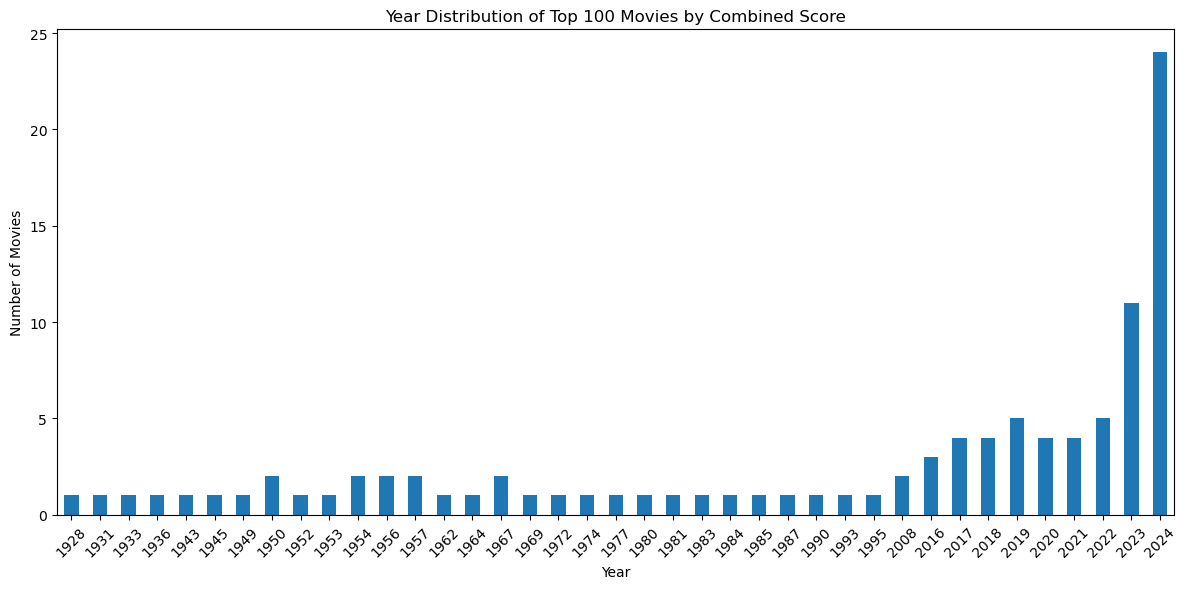


Average runtime: 109.09 minutes

Overlap Analysis:
Movies in both Critic and User top 100: 3
Movies in both Critic and Combined top 100: 10
Movies in both User and Combined top 100: 45
Movies in all three top 100 lists: 3

Movies in all three top 100 lists:
['Who Killed Captain Alex?', 'Sex Weather', 'Sex Doll']


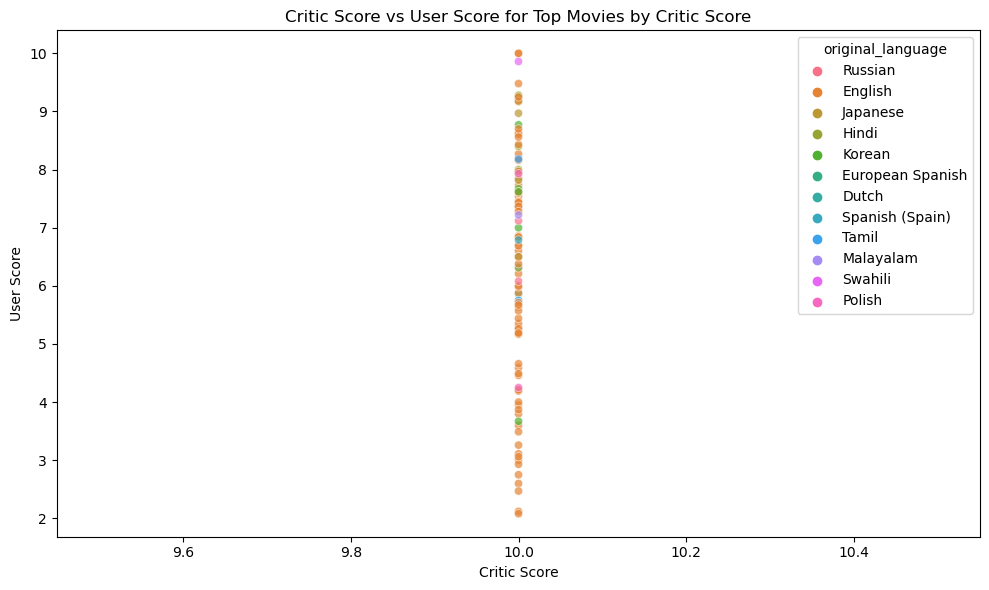

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_dataset is already loaded

def get_top_100(df, score_column):
    return df.nlargest(100, score_column)

# Get top 100 for each score type
top_100_critic = get_top_100(merged_dataset, 'critic_score')
top_100_user = get_top_100(merged_dataset, 'user_score')
top_100_combined = get_top_100(merged_dataset, 'average_combined_score')

def inspect_data(df, score_type):
    print(f"\nInspecting data for {score_type}:")
    print("Columns in the DataFrame:")
    print(df.columns)
    print("\nData types:")
    print(df.dtypes)
    print("\nFirst few rows:")
    print(df.head())

    # Check for score columns
    score_columns = [col for col in df.columns if 'score' in col.lower()]
    for col in score_columns:
        print(f"\nUnique values in {col}:")
        print(df[col].unique())

# Inspect each dataset
inspect_data(top_100_critic, "Critic Score")
inspect_data(top_100_user, "User Score")
inspect_data(top_100_combined, "Combined Score")

def analyze_top_100(df, score_type):
    print(f"\nAnalyzing Top 100 Movies by {score_type}:")

    if 'original_language' in df.columns:
        print("\nLanguage distribution:")
        print(df['original_language'].value_counts())

    if 'movie_year' in df.columns:
        print("\nYear distribution:")
        year_counts = df['movie_year'].value_counts().sort_index()
        print(year_counts)

        # Plotting year distribution
        plt.figure(figsize=(12, 6))
        year_counts.plot(kind='bar')
        plt.title(f'Year Distribution of Top 100 Movies by {score_type}')
        plt.xlabel('Year')
        plt.ylabel('Number of Movies')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    if 'runtime_in_minutes' in df.columns:
        print(f"\nAverage runtime: {df['runtime_in_minutes'].mean():.2f} minutes")

# Analyze each top 100 list
analyze_top_100(top_100_critic, 'Critic Score')
analyze_top_100(top_100_user, 'User Score')
analyze_top_100(top_100_combined, 'Combined Score')

# Compare overlap between lists if 'movie_title' is present
if 'movie_title' in top_100_critic.columns and 'movie_title' in top_100_user.columns and 'movie_title' in top_100_combined.columns:
    critic_user_overlap = set(top_100_critic['movie_title']) & set(top_100_user['movie_title'])
    critic_combined_overlap = set(top_100_critic['movie_title']) & set(top_100_combined['movie_title'])
    user_combined_overlap = set(top_100_user['movie_title']) & set(top_100_combined['movie_title'])
    all_overlap = set(top_100_critic['movie_title']) & set(top_100_user['movie_title']) & set(top_100_combined['movie_title'])

    print("\nOverlap Analysis:")
    print(f"Movies in both Critic and User top 100: {len(critic_user_overlap)}")
    print(f"Movies in both Critic and Combined top 100: {len(critic_combined_overlap)}")
    print(f"Movies in both User and Combined top 100: {len(user_combined_overlap)}")
    print(f"Movies in all three top 100 lists: {len(all_overlap)}")

    print("\nMovies in all three top 100 lists:")
    print(list(all_overlap))
else:
    print("\nUnable to perform overlap analysis due to missing 'movie_title' column.")

# Attempt to create a scatter plot if numeric score columns are present
if 'critic_score' in top_100_critic.columns and 'user_score' in top_100_critic.columns:
    if pd.api.types.is_numeric_dtype(top_100_critic['critic_score']) and pd.api.types.is_numeric_dtype(top_100_critic['user_score']):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=top_100_critic, x='critic_score', y='user_score', hue='original_language', alpha=0.7)
        plt.title('Critic Score vs User Score for Top Movies by Critic Score')
        plt.xlabel('Critic Score')
        plt.ylabel('User Score')
        plt.tight_layout()
        plt.show()
    else:
        print("\nUnable to create scatter plot due to non-numeric score data.")
else:
    print("\nUnable to create scatter plot due to missing score columns.")


Critic Score Analysis:

Language: English dominates (72%), but there's significant diversity with Korean, Hindi, and Japanese films in the top 100.
Year Distribution: There's a strong recency bias, with 65% of top critic-rated movies from 2016-2022.
Average Runtime: 104.71 minutes


User Score Analysis:

Language: English is even more dominant (83%), with less language diversity than critic scores.
Year Distribution: Extreme recency bias, with all top 100 movies from 2017-2024, and 70% from just 2023-2024.
Average Runtime: 97.28 minutes, shorter than critic favorites.


Combined Score Analysis:

Language: English still dominates (73%), but with more diversity than user scores.
Year Distribution: More balanced across years, with representation from 1928 to 2024, though still skewed towards recent years.
Average Runtime: 109.09 minutes, longer than both critic and user top 100 lists.


Overlap Analysis:

Only 3 movies appear in all three top 100 lists: "Who Killed Captain Alex?", "Sex Weather", and "Sex Doll".
There's more overlap between user and combined scores (45 movies) than between critic and combined scores (10 movies).



Key Insights:

Recency Bias: Users show a strong preference for very recent movies, while critics have a more balanced view across decades. The combined score bridges this gap somewhat.
Language Preference: While English-language films dominate all lists, critics tend to recognize a more diverse range of languages compared to general users.
Runtime: Movies with longer runtimes tend to be favored in the combined score list, suggesting that films with more depth or complexity might be rewarded when considering both critic and user opinions.
Divergence in Taste: The low overlap between critic and user top 100 lists (only 3 movies) indicates a significant difference in what critics value versus what general audiences enjoy.
Niche Appeal: The three movies that appear in all lists are relatively obscure titles, suggesting that sometimes smaller, unique films can achieve universal appeal.
Historical Appreciation: The combined score list includes more classic films, indicating the importance of lasting impact and historical significance in overall film appreciation.

What Makes a "Good" Movie:

For Critics:

Artistic merit and innovation
Diverse language representation
Balanced consideration of both recent and classic films


For Users:

Strong recency factor (very latest releases)
Slightly shorter runtimes
More focus on English-language content


For Combined Appeal:

Slightly longer runtimes, allowing for more depth
Balance between recent releases and classic films
Moderate language diversity



To create a widely acclaimed movie:

Aim for a runtime around 110 minutes.
Consider making it in English, but don't shy away from other languages, especially for critical acclaim.
Focus on unique, compelling storytelling that can appeal to both critics and general audiences.
Remember that user ratings tend to favor very recent releases, while enduring classics are recognized in combined scores.
Strive for a balance between artistic merit (for critics) and entertainment value (for users).

The low overlap between lists suggests that aiming to please both critics and general audiences simultaneously is challenging but potentially very rewarding for those few films that manage to do so.

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from tabulate import tabulate

def display_top_100(df, score_type):
    # Create a dictionary to map score types to actual column names
    score_column_map = {
        'Critic Score': 'critic_score',
        'User Score': 'user_score',
        'Average Combined Score': 'average_combined_score'
    }

    # Get the actual column name for the score
    score_column = score_column_map.get(score_type, score_type)

    # Select relevant columns
    display_columns = ['movie_title', 'movie_year', 'original_language', 'runtime_in_minutes', score_column]

    # Sort by the score type and select top 100
    top_100 = df.sort_values(score_column, ascending=False).head(100)[display_columns]

    # Rename columns for display
    top_100 = top_100.rename(columns={
        'movie_title': 'Title',
        'movie_year': 'Year',
        'original_language': 'Language',
        'runtime_in_minutes': 'Runtime (min)',
        score_column: 'Score'
    })

    # Reset index to start from 1
    top_100 = top_100.reset_index(drop=True)
    top_100.index += 1

    # Display the table
    print(f"\nTop 100 Movies by {score_type}:")
    print(tabulate(top_100, headers='keys', tablefmt='pretty', showindex=True))

    # Optionally, save to CSV
    csv_filename = f"top_100_{score_type.lower().replace(' ', '_')}.csv"
    top_100.to_csv(csv_filename, index=False)
    print(f"\nCSV file saved as: {csv_filename}")

# Assuming merged_dataset is your main dataset
# Call the function for each score type
display_top_100(merged_dataset, 'Critic Score')
display_top_100(merged_dataset, 'User Score')
display_top_100(merged_dataset, 'Average Combined Score')


Top 100 Movies by Critic Score:
+-----+------------------------------------------------------+------+------------------+---------------+-------+
|     |                        Title                         | Year |     Language     | Runtime (min) | Score |
+-----+------------------------------------------------------+------+------------------+---------------+-------+
|  1  |                 The Three Musketeers                 | 2011 |     English      |      105      | 10.0  |
|  2  |                    Bangalore Days                    | 2019 |    Malayalam     |      171      | 10.0  |
|  3  |     Escaping the Madhouse: The Nellie Bly Story      | 2019 |     English      |      90       | 10.0  |
|  4  |             Shane Gillis: Beautiful Dogs             | 2023 |     English      |      52       | 10.0  |
|  5  |             The Bad Guys: Reign of Chaos             | 2019 |      Korean      |      113      | 10.0  |
|  6  |                     A.I. Rising                      | 

In [ ]:
import pandas as pd

# Assuming you have the CSV files saved from the previous analysis
critic_top_100 = pd.read_csv("top_100_critic_score.csv")
user_top_100 = pd.read_csv("top_100_user_score.csv")
combined_top_100 = pd.read_csv("top_100_average_combined_score.csv")

# Find the movies that appear in all three lists
shared_movies = set(critic_top_100['Title']) & set(user_top_100['Title']) & set(combined_top_100['Title'])

print(f"Number of movies shared across all three top 100 lists: {len(shared_movies)}")
print("\nMovies shared across all three lists:")
for movie in shared_movies:
    print(movie)

# Merge the dataframes to get detailed information for shared movies
merged_df = pd.merge(critic_top_100, user_top_100, on=['Title', 'Year', 'Language', 'Runtime (min)'], how='inner', suffixes=('_Critic', '_User'))
merged_df = pd.merge(merged_df, combined_top_100, on=['Title', 'Year', 'Language', 'Runtime (min)'], how='inner')

# Rename columns for clarity
merged_df = merged_df.rename(columns={'Score': 'Combined Score', 'Score_Critic': 'Critic Score', 'Score_User': 'User Score'})

# Filter for the shared movies
shared_movies_df = merged_df[merged_df['Title'].isin(shared_movies)]

# Display detailed information for shared movies
print("\nDetailed information for shared movies:")
print(shared_movies_df.to_string(index=False))

# Analyze characteristics of shared movies
print("\nCharacteristics of shared movies:")
print(f"Average Year: {shared_movies_df['Year'].mean():.2f}")
print(f"Average Runtime: {shared_movies_df['Runtime (min)'].mean():.2f} minutes")
print("\nLanguage Distribution:")
print(shared_movies_df['Language'].value_counts())

# Save the detailed information to a CSV file
shared_movies_df.to_csv("shared_top_movies.csv", index=False)
print("\nDetailed information saved to 'shared_top_movies.csv'")


Number of movies shared across all three top 100 lists: 6

Movies shared across all three lists:
The Real Bros of Simi Valley: The Movie
The American
Sex Doll
South Park: Joining the Panderverse
Who Killed Captain Alex?
Sex Weather

Detailed information for shared movies:
                                  Title  Year Language  Runtime (min)  Critic Score  User Score  Combined Score
               Who Killed Captain Alex?  2019  Swahili             64          10.0        9.86            9.93
    South Park: Joining the Panderverse  2023  English             48          10.0        9.60            9.80
                               Sex Doll  2017  English            104          10.0       10.00           10.00
The Real Bros of Simi Valley: The Movie  2024  English            120          10.0        9.81            9.90
                            Sex Weather  2018  English             90          10.0       10.00           10.00
                           The American  2024  English 

Sex Doll  
Sex Weather  
The American  

These are the top three movies in all datasets with a user score of 10, critic score of 10 and combined of 10.